In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from geopy.geocoders import Nominatim # for latitudes and longitudes
import json

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.2.4
Sklearn  0.24.2


### Importing Dataset

In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "umutakta"
    os.environ['KAGGLE_KEY']      = "a471e5474add8d57cadac3cc5ff2b1d6"  
    !pip install --upgrade kaggle
    !kaggle competitions download -c competitive-data-science-predict-future-sales
    DATA_PATH = "/work/Strive_School/Feature_Engineering_(Module_4)/Day_6_Feature_Selection/competitive-data-science-predict-future-sales/"

else:
    DATA_PATH = "/work/Data_Sets/competitive-data-science-predict-future-sales/"

DATA_PATH

'/work/Data_Sets/competitive-data-science-predict-future-sales/'

**Creating Data Frame**

In [50]:
df_item_categ=pd.read_csv(DATA_PATH+"item_categories_eng.csv")
df_items=pd.read_csv(DATA_PATH+"items_eng.csv")
df=pd.read_csv(DATA_PATH+"sales_train.csv")
df_sample=pd.read_csv(DATA_PATH+"sample_submission.csv")
df_shops=pd.read_csv(DATA_PATH+"shops_eng.csv")
df_test=pd.read_csv(DATA_PATH+"test.csv")

In [4]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Turning date column to **date type**

In [5]:
from datetime import datetime

df["date"]=df['date'].apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))


### Deleting Outliers

**Item Count Day**

In [6]:
df=df.drop(df.loc[df.item_cnt_day>800].index.tolist())

<AxesSubplot:xlabel='item_cnt_day'>

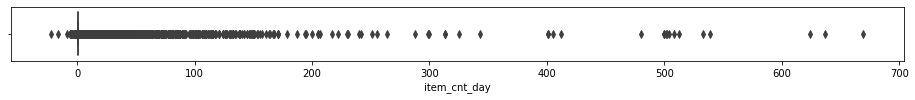

In [7]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_cnt_day)

**Item Price**

In [8]:
df=df.drop(df.loc[df.item_price>10000].index.tolist())

<AxesSubplot:xlabel='item_price'>

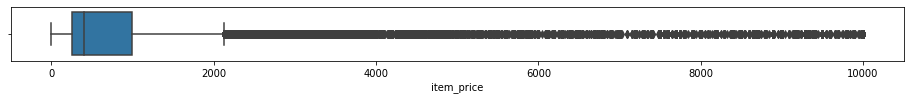

In [9]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_price)

#### Creating new data frame for only 2013,2014,2015

In [10]:
df_2013=df[(df.date<"01-01-2014") & ("31-12-2012"<df.date)]
df_2014=df[(df.date<"01-01-2015") & ("31-12-2013"<df.date)]
df_2015=df[(df.date<"01-01-2016") & ("31-12-2014"<df.date)]

** Grouping monthly sales **

In [11]:
df_2013['total_income_13']=df_2013.item_price*df_2013.item_cnt_day
df13_total=df_2013.groupby(['date_block_num']).sum()

df_2014['total_income_14']=df_2014.item_price*df_2014.item_cnt_day
df14_total=df_2014.groupby(['date_block_num']).sum()

df_2015['total_income_15']=df_2015.item_price*df_2015.item_cnt_day
df15_total=df_2015.groupby(['date_block_num']).sum()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

** Plot by total income for 2013 and 2014**

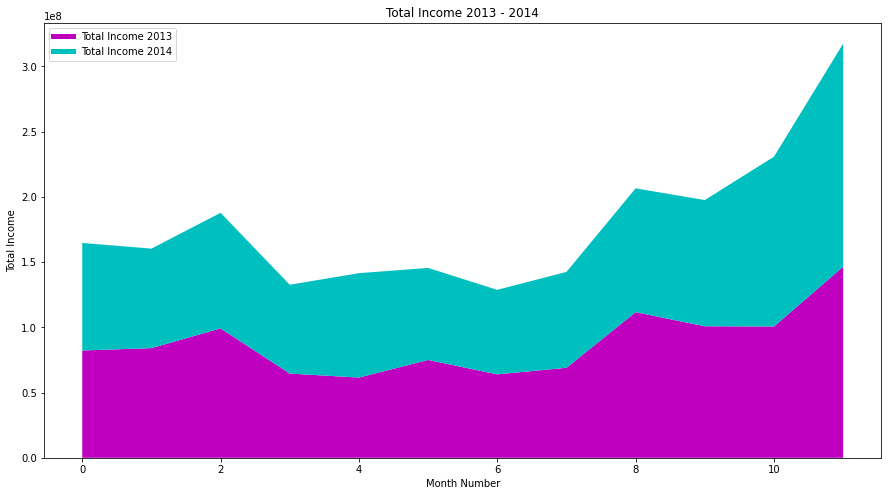

In [12]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='m', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='c', label='Total Income 2014', linewidth=5)

plt.stackplot(df13_total.index, df13_total.total_income_13, df14_total.total_income_14,colors=['m','c'])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

** Total Income Plotting Until October in 2013,2014 and 2015 **

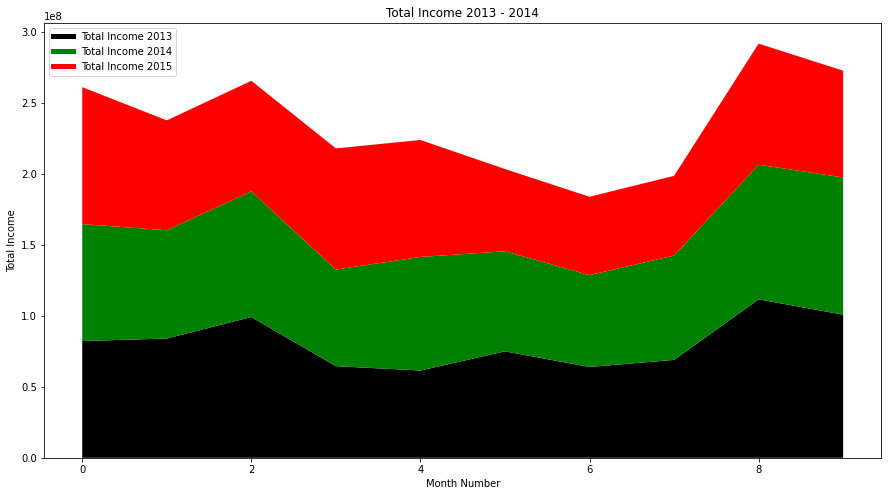

In [13]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='k', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='g', label='Total Income 2014', linewidth=5)
plt.plot([],[],color='r', label='Total Income 2015', linewidth=5)

plt.stackplot(df13_total.index[:10], df13_total.loc[:9].total_income_13, 
    df14_total.loc[:21].total_income_14,df15_total.total_income_15,colors=['k','g',"r"])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

#### Interesting with shop id

Finding different shops between years 2013, 2014 and 2015

In [14]:
set_difference_13_14 = set(df_2013.shop_id.unique()) - set(df_2014.shop_id.unique())
difference_13_14 = list(set_difference_13_14)

set_difference_13_15 = set(df_2013.shop_id.unique()) - set(df_2015.shop_id.unique())
difference_13_15 = list(set_difference_13_15)

difference_13_14.extend(difference_13_15)
difference_13=difference_13_14
difference_13

[0, 1, 32, 8, 23, 0, 1, 32, 8, 13, 23]

In [15]:
set_difference_14_15 = set(df_2014.shop_id.unique()) - set(df_2015.shop_id.unique())
difference_14_15 = list(set_difference_14_15)

set_difference_14_13 = set(df_2014.shop_id.unique()) - set(df_2013.shop_id.unique())
difference_14_13 = list(set_difference_14_13)

difference_14_13.extend(difference_14_15)
difference_14=difference_14_13
difference_14

[33, 34, 39, 40, 48, 20, 13]

In [16]:
set_difference_15_13 = set(df_2015.shop_id.unique()) - set(df_2013.shop_id.unique())
difference_15_13 = list(set_difference_15_13)

set_difference_15_14 = set(df_2015.shop_id.unique()) - set(df_2014.shop_id.unique())
difference_15_14 = list(set_difference_15_14)

difference_15_14.extend(difference_15_13)
difference_15=difference_15_14
difference_15

[11, 36, 33, 34, 36, 39, 40, 11, 48, 20]

In [17]:
# Dropping different shops from 2013 and 2014
df_2013_drop_shops=df_2013.groupby(["shop_id"]).sum().drop(difference_13, axis=0)
df_2014_drop_shops=df_2014.groupby(["shop_id"]).sum().drop(difference_14, axis=0)
df_2015_drop_shops=df_2015.groupby(["shop_id"]).sum().drop(difference_15, axis=0)

** Plot Total Income Per Shop **

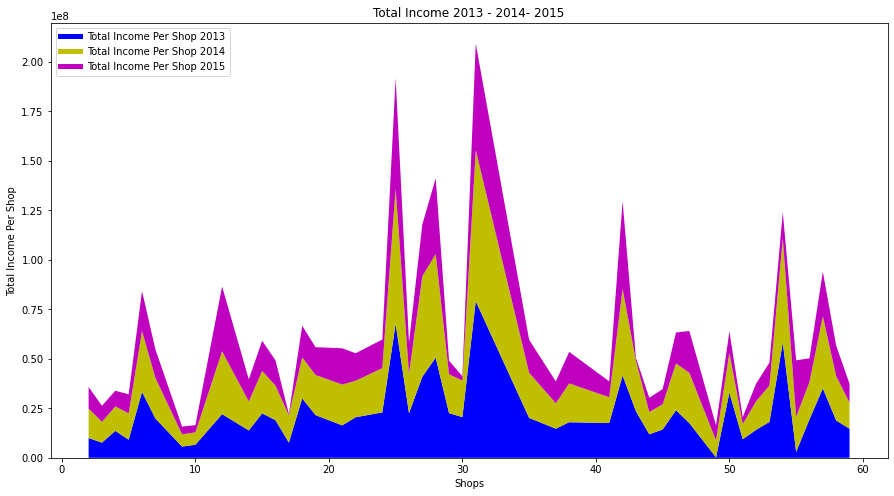

In [18]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='b', label='Total Income Per Shop 2013', linewidth=5)
plt.plot([],[],color='y', label='Total Income Per Shop 2014', linewidth=5)
plt.plot([],[],color='m', label='Total Income Per Shop 2015', linewidth=5)

plt.stackplot(df_2013_drop_shops.index, df_2013_drop_shops.total_income_13, 
    df_2014_drop_shops.total_income_14,df_2015_drop_shops.total_income_15,colors=['b','y',"m"])

plt.xlabel('Shops')
plt.ylabel('Total Income Per Shop')
plt.title('Total Income 2013 - 2014- 2015')
plt.legend(loc='upper left')
plt.show()

## Shop Data

### Cleaning Data

**Dropping duplicate shops**



In [19]:
df_shops=df_shops.drop([10,39,0]).reset_index()

** Identifying Cities **

In [20]:
#Cleaning shop name
df_shops['shop_names_cleaned'] = [df_shops['shop_name'][i].replace('!', '').replace('?', '')
    .replace('²', '').replace('" ', ' ').replace(' "', ' ').replace('"', '')
    .replace('-', ' ').strip() for i in range(df_shops.shape[0])]


cities= lambda x: x.split(" ")[0]
df_shops["city"]=df_shops.shop_names_cleaned.map(cities)
for i in range(len(df_shops["city"])):
    if df_shops["city"][i]=="St.":
        df_shops["city"][i]="Saint Petersburg"
    if df_shops["city"][i]=="Adygeya":
        df_shops["city"][i]="Tul’skiy"


df_shops=df_shops.replace(["St.","Adygea","N.Novgorod",'RostovNaDon','RostovNaDonu','Sergiev','Volga','Zhukovsky'],
    ["Saint Petersburg","Tul’skiy","Nizhniy Novgorod","Rostov","Rostov","Sergiyev Posad","Tver","Moscow"])


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


** Identifying Shops **

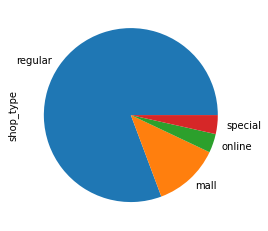

In [21]:
df_shops['shop_type'] = 'regular' # By default all shops are regular shops

#there is some overlap in tc and mall, mall is given precedence
df_shops.loc[ df_shops['shop_name'].str.contains(r'tc'), 'shop_type' ]               = 'tc'
df_shops.loc[ df_shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type' ] = 'mall'
df_shops.loc[ df_shops.shop_id.isin([9,20]), 'shop_type' ]                             = 'special'
df_shops.loc[ df_shops.shop_id.isin([12,55]), 'shop_type' ]                            = 'online'

df_shops['shop_type'].value_counts().plot.pie();

latitude_list, longitude_list=[],[]

for i in df_shops.cleaned:

    geolocator = Nominatim(user_agent="foursquare_agent")
    
    #geolocator = Nominatim(user_agent="my_user_agent")
    location = geolocator.geocode(i)
    try:
        latitude = location.latitude
        latitude_list.append(latitude)
    except:
        latitude_list.append(np.nan)

    try:    
        longitude = location.longitude
        longitude_list.append(longitude)
    except:
        longitude_list.append(np.nan)

df_shops["latitude"]=latitude_list
df_shops["longitude"]=longitude_list



### Russia Population Dataset

In [22]:
df_pop=pd.read_csv("/work/Data_Sets/competitive-data-science-predict-future-sales/ru_population.csv")


In [23]:
city_difference= set(df_shops.city.unique())-set(df_pop.city.unique())
city_difference

{'Digital', 'Internet', 'Outbound'}

### Creating New Merged Dataframe

In [24]:
df_new_shop=pd.merge(df_pop, df_shops, on=['city'])
df_new_shop=df_new_shop.drop(["country","iso2","admin_name","index","shop_name","shop_name"],axis=1).drop_duplicates(subset=['shop_names_cleaned']).reset_index()
df_new_shop=df_new_shop.drop(["shop_names_cleaned","lat","lng","index"],axis=1)

In [25]:
online_shop_1 = {'city':"no_city","capital":"no_capital","population":0,
    "population_proper":0,"shop_id":55,"shop_type":"online"}

online_shop_2 = {'city':"no_city","capital":"no_capital","population":0,
    "population_proper":0,"shop_id":12,"shop_type":"online"}


online_shop_3 = {'city':"no_city","capital":"no_capital","population":0,
    "population_proper":0,"shop_id":9,"shop_type":"online"}



#append row to the dataframe
df_new_shop = df_new_shop.append(online_shop_1, ignore_index=True)
df_new_shop = df_new_shop.append(online_shop_2, ignore_index=True)
df_new_shop = df_new_shop.append(online_shop_3, ignore_index=True)


** Handling null values**

In [26]:
df_new_shop.capital.fillna("minor", inplace = True)
df_new_shop.population.fillna(1553925,inplace = True)
df_new_shop.population_proper.fillna(1491855,inplace = True)
df_new_shop.head()

,city,capital,population,population_proper,shop_id,shop_type
0,Moscow,primary,17125000.0,13200000.0,11,regular
1,Moscow,primary,17125000.0,13200000.0,20,special
2,Moscow,primary,17125000.0,13200000.0,21,regular
3,Moscow,primary,17125000.0,13200000.0,22,regular
4,Moscow,primary,17125000.0,13200000.0,23,regular


In [27]:
df_new_shop.isnull().sum()

city                 0
capital              0
population           0
population_proper    0
shop_id              0
shop_type            0
dtype: int64

## Item Category Data

In [28]:
#df_item_categ["main_categories"]=0
find_main_categories=lambda x: x.split("-")[0].strip()
df_item_categ["main_categories"]=df_item_categ.category_name.map(find_main_categories)
df_item_categ.head()

,category_name,category_id,main_categories
0,PC - Headsets / Headphones,0,PC
1,Accessories - PS2,1,Accessories
2,Accessories - PS3,2,Accessories
3,Accessories - PS4,3,Accessories
4,Accessories - PSP,4,Accessories


## Item Data

### Cleaning

In [29]:
df_items['item_name'] = df_items['item_name'].str.lower()
df_items['item_name'] = df_items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',  
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    df_items['item_name'] = df_items['item_name'].str.replace(i, ' ')
df_items['item_name'] = df_items['item_name'].str.replace(r'\b.\b', ' ').str.strip()


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


** Finding Duplicates **

In [30]:
dupes = df_items[(df_items.duplicated(subset=['item_name','category_id'],keep=False))]
dupes['in_test'] = dupes.item_id.isin(df_test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':["count",'first','last'],'in_test':['first','last']})

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


** Removing Duplicates **

In [31]:
# A) if both item id's are in the test set do nothing
dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]

# B) if only the first id is in the test set assign this id to both
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))

# C) if neither id or only the second id is in the test set, assign the second id to both
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

** Saving Item Map **

In [32]:
json_filename = DATA_PATH + 'duplicated_items_replacement.json'

json.dump(item_map, open(json_filename, 'w'), indent=4)

### Encoding For Item

In [33]:
df_items['item_name_no_space'] = df_items['item_name'].str.replace(' ', '')
df_items['item_name_first4']   = [x[:4] for x in df_items['item_name_no_space']]
df_items['item_name_first6']   = [x[:6] for x in df_items['item_name_no_space']]
df_items['item_name_first11']  = [x[:11] for x in df_items['item_name_no_space']]
del df_items['item_name_no_space']

df_items.head()

## Creating New Data Frame Items With Categories

In [34]:
df_new_items=pd.merge(df_item_categ, df_items, on=['category_id'])
df_new_items.head()

,category_name,category_id,main_categories,item_id,item_name,item_name_first4,item_name_first6,item_name_first11
0,PC - Headsets / Headphones,0,PC,5441,pc headset hyperx cloud core gaming stereo k...,pche,pchead,pcheadsethy
1,PC - Headsets / Headphones,0,PC,16255,headphones philips sbc hc8680,head,headph,headphonesp
2,PC - Headsets / Headphones,0,PC,16256,headphones ritmix rh 120,head,headph,headphonesr
3,PC - Headsets / Headphones,0,PC,16257,headphones ritmix rh 124 black,head,headph,headphonesr
4,Accessories - PS2,1,Accessories,5606,ps2 memory card mb black memory card 8mb ...,ps2m,ps2mem,ps2memoryca


## Sales Data

### Creating Time Data

In [35]:
time = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01', end='2015-11-30')})

time['month']          = time.date.dt.month 
time['year']           = time.date.dt.year - 2013
time["day_of_week"]    = time.date.dt.dayofweek + 1
time["day_of_month"]   = time.date.dt.day
time['day_of_year']    = time.date.dt.dayofyear
time["day_of_history"] = time.day_of_year + (365 * time.year)
time['date_block_num'] = time['year']*12 + time['month'] - 1
time.set_index('date', inplace=True)


In [36]:
days_of_week = ["#mon", "#tue", "#wed", "#thu", "#fri", "#sat", "#sun"]

months = time.groupby(["date_block_num", "day_of_week"]).size().unstack()
months.columns = days_of_week
months["#sat+sun"] = months["#sat"] + months["#sun"]

months["#days"] = months[days_of_week].sum(1)
#months["month_id"]   = months.index%12 + 1

date_block_num_list=list(df.date_block_num.unique())
date_block_num_list.append(34)
months["date_block_num"]=date_block_num_list
months.head()

,#mon,#tue,#wed,#thu,#fri,#sat,#sun,#sat+sun,#days,date_block_num
date_block_num,,,,,,,,,,
0,4,5,5,5,4,4,4,8,31,0
1,4,4,4,4,4,4,4,8,28,1
2,4,4,4,4,5,5,5,10,31,2
3,5,5,4,4,4,4,4,8,30,3
4,4,4,5,5,5,4,4,8,31,4


** Merging Time and Sales Data **

In [54]:
df=pd.merge(df.reset_index(), months, on=['date_block_num'])
df

ValueError: 'date_block_num' is both an index level and a column label, which is ambiguous.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=796ba814-f632-4502-b0d7-7e2f8f9e546d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>